In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [37]:
#img_rows, img_cols, img_chns = 32, 32, 3
img_rows, img_cols, img_chns = 2, 2, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
sample = 1

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 2))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 2))

# Make Dummy Image

In [38]:
X_train = np.zeros([1, 2, 2, 3])
X_train[0, 0, 0, :] = [105, 160, 30]
X_train[0, 0, 1, :] = [140, 150, 160]
X_train[0, 1, 0, :] = [200, 210, 220]
X_train[0, 1, 1, :] = [230, 240, 250]


display(X_train)

X_train = (X_train - 127.5) / 127.5

array([[[[105., 160.,  30.],
         [140., 150., 160.]],

        [[200., 210., 220.],
         [230., 240., 250.]]]])

# Model

In [39]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        x = Activation('relu')(x)
        #x = Lambda(lambda x: x, name='debug_' + name + t)(x)
        outs.append(x)
        
    return Concatenate()(outs)


def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * final_filters])(input_tensor)
       
        decoder_out_m_ = Flatten()(x)
        decoder_out_m_ = Dense(500, activation='relu')(decoder_out_m_)
        decoder_out_m_ = Dense(500, activation='relu')(decoder_out_m_)
        decoder_out_m_ = Dense(500, activation='relu')(decoder_out_m_)
        decoder_out_m_ = Dense(img_rows * img_cols * mixture_components)(decoder_out_m_)
        decoder_out_m = Reshape((img_rows, img_cols, mixture_components))(decoder_out_m_)
        
        decoder_out_invs_ = Flatten()(x)
        decoder_out_invs_ = Dense(500, activation='relu')(decoder_out_invs_)
        decoder_out_invs_ = Dense(500, activation='relu')(decoder_out_invs_)
        decoder_out_invs_ = Dense(500, activation='relu')(decoder_out_invs_)
        decoder_out_invs_ = Dense(img_rows * img_cols * mixture_components, activation='softplus')(decoder_out_invs_)
        decoder_out_invs = Reshape((img_rows, img_cols, mixture_components))(decoder_out_invs_)
        
        decoder_out_weights_ = Flatten()(x)
        decoder_out_weights_ = Dense(500, activation='relu')(decoder_out_weights_)
        decoder_out_weights_ = Dense(500, activation='relu')(decoder_out_weights_)
        decoder_out_weights_ = Dense(500, activation='relu')(decoder_out_weights_)
        decoder_out_weights_ = Dense(img_rows * img_cols * mixture_components)(decoder_out_weights_)
        mixture_weights = Reshape((img_rows, img_cols, mixture_components))(decoder_out_weights_)
        
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    
    return Concatenate()([out_m, out_invs, out_mixture])

In [40]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 128, (3, 3), name='conv1', is_first=True)
x = build_outputs(x, 1)

main_output = x

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.001)
#optimizer = SGD(lr=0.001)
#optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))
model.summary()

Building conv layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2, 2, 3)      0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 2, 2, 128)    3584        main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 2, 2, 128)    3584        main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 2, 2, 128)    3584        main_input[0][0]                 
___________________________________________________________________

In [41]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_2019-05-13/' + str(int(time.time() % 10000)),
                                          histogram_freq=1, batch_size=1,
                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=50,
    callbacks=[TQDMNotebookCallback()],#, tensorboard], #early_stopping, reduce_lr],
    validation_data=(X_train, X_train),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  7.25688624382019


,val_loss,loss
count,50.000000,50.000000
mean,67.183327,67.744082
std,15.435759,15.517387
min,50.945869,50.945869
0%,50.945869,50.945869
25%,56.467880,56.700644
50%,61.099430,62.043522
75%,78.215359,79.170528
95%,83.436731,83.566239
99%,112.370164,112.406202


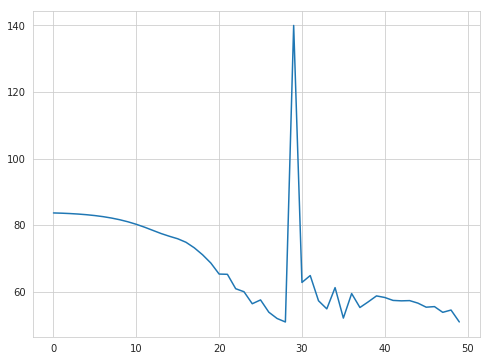

In [42]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [43]:
#print(df)

(2, 20, 3)
==== 0 0 0
X_train[0 0 0 0 ] =  -0.17647058823529413  (105.0)
 m:  [-0.14834623 -0.37673792] ([108.58585  79.46591])
 E[m]:  -0.24072534 ([108.58585  79.46591])
 invs:  [3.1354184 2.4239502]
 weights:  [0.5955234  0.40447664]  ( [ 0.19130075 -0.19554593] )
 pvals:  86     0.010012
87     0.010131
88     0.010288
89     0.010497
90     0.010770
91     0.011124
92     0.011571
93     0.012129
94     0.012809
95     0.013625
96     0.014585
97     0.015694
98     0.016948
99     0.018336
100    0.019834
101    0.021407
102    0.023005
103    0.024566
104    0.026018
105    0.027281
106    0.028279
107    0.028942
108    0.029217
109    0.029074
110    0.028512
111    0.027555
112    0.026250
113    0.024666
114    0.022877
115    0.020963
116    0.018998
117    0.017046
118    0.015159
119    0.013376
120    0.011723
121    0.010214
dtype: float64
 pixel_val:  97
==== 0 0 1
X_train[0 0 0 1 ] =  0.2549019607843137  (160.0)
 m:  [0.18565957 0.2306457 ] ([151.1716  156.90733])
 E[

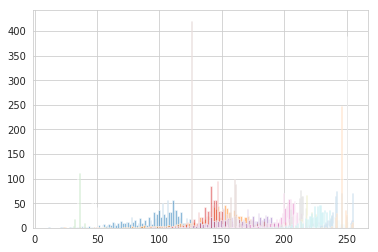

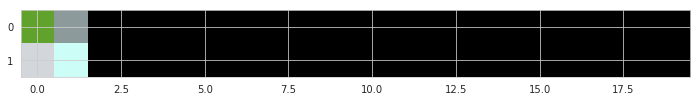

Elapsed:  3.8359806537628174


In [44]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                # =======================================================
                #x_out = model.predict(X_train, num_samples)
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components

                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = (pixel_val - 127.5) / 127.5
                    if 0 <= i <= 16 and 0 <= j <= 16 and debug:
                        print("====", i, j, k)
                        print("X_train[0", i, j, k, "] = ", X_train[0, i, j, k], 
                              " (%s)" % (X_train[0, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms, "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" E[m]: ", (x_ms * weights).sum(), "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" invs: ", x_invs)
                        print(" weights: ", weights, " (", x_out[n, i, j, offset:offset + mixture_components] ,")")
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
                        #print("====", i, j, k)
                        #print(" m: ", x_ms)
                        #print(" invs: ", x_invs)
                        #print(" weights: ", weights)
                        #print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
        if debug:
            print("row", i)
        
                
    return (x_sample * 127.5 + 127.5)


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * 10, img_chns))
print(figure.shape)
# num_samples = batch_size
num_samples = 1
for i in range(1):
    samples = gen_image(model, num_samples=num_samples)
    for j in range(num_samples):
        img = samples[j] / 255.
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

In [45]:
display(X_train[0] * 127.5 + 127.5)
display(samples[0])

array([[[105., 160.,  30.],
        [140., 150., 160.]],

       [[200., 210., 220.],
        [230., 240., 250.]]])

array([[[ 97., 162.,  45.],
        [140., 154., 155.]],

       [[211., 215., 220.],
        [204., 254., 247.]]])

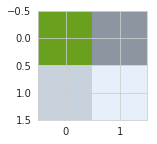

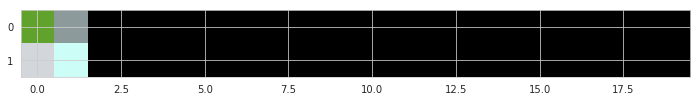

array([[[0.38039216, 0.63529412, 0.17647059],
        [0.54901961, 0.60392157, 0.60784314],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.82745098, 0.84313725, 0.8627451 ],
        [0.8       , 0.99607843,

In [46]:
plt.figure(figsize=(2, 2))
plt.imshow((X_train[0] * 127.5 + 127.5) / 255.)
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

figure

# 2019-05-13

* I was having trouble fitting even this small image -- it seems like the 'relu' activation right after the PixelConv2D layer at the very start was causing the problem.  Getting rid of that `relu` make it fit almost exactly now (after enough epochs).
* I suspect that's because most of the activations were negative, thus passing through `relu` caused it to be near zero output causing no learning to happen?
* Here's an example of (1, 1, 3) image, with 10 filters on initial `PixelConv2D` layer, followed by `Dense` layers to match the right output formats for m, invs, weights.  You can see that we're almost bang on for each pixel, centered at the actual pixel, with almost all the mass within 2-3 intensity values:

        ==== 0 0 0
        X_train[0, i, j, k] =  -0.6862745098039216  (40.0)
         m:  [-0.6863073]
         E[m]:  -0.6863073
         invs:  [4.973635]
         weights:  [1.]
         pvals:  36    0.012568
        37    0.037100
        38    0.099260
        39    0.208047
        40    0.276076
        41    0.207095
        42    0.098519
        43    0.036775
        44    0.012452
        dtype: float64
         pixel_val:  42
        ==== 0 0 1
        X_train[0, i, j, k] =  -0.37254901960784315  (80.0)
         m:  [-0.37255913]
         E[m]:  -0.37255913
         invs:  [5.821288]
         weights:  [1.]
         pvals:  78    0.017253
        79    0.192262
        80    0.579408
        81    0.191254
        82    0.017138
        dtype: float64
         pixel_val:  80
        ==== 0 0 2
        X_train[0, i, j, k] =  -0.058823529411764705  (120.0)
         m:  [-0.05882262]
         E[m]:  -0.058822624
         invs:  [6.2373266]
         weights:  [1.]
         pvals:  119    0.116113
        120    0.762810
        121    0.116207
        dtype: float64
         pixel_val:  120
         
* Tried growing to 2x2 image size, it almost looks like it tries to fit the first pixel only (40, 80, 120) and all the other pixels get distributions like that.  It's quite likely because I don't have enough depth.  For example, after getting rid of the activation on the first layer, the `m` is purely a linear function through the `PixelConv2D` and `Dense` layer.
* TODO: Try adding depth to the `Dense` layers to give the network a bit capacity.

# 2019-05-25

* Debugging network by fixing weights (single mixture so doens't matter) and `invs` to different fixes values
* Also setting all activations to `tanh` (setting it to `sigmoid` doesn't seem to work?)
* Setting `invs={1, 3, 5}` both pretty messy not real convergence but... setting `invs=2` gave me really tight `m`s but notice that `invs=2` is a really wide distribution... could be spread over > 100 even though the center is right.. still need to figure out what's going on:

        ==== 0 0 0
        X_train[0 0 0 0 ] =  -0.17647058823529413  (105.0)
         m:  [-0.19976245] ([102.03029])
         E[m]:  -0.19976245 ([102.03029])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  116
        ==== 0 0 1
        X_train[0 0 0 1 ] =  0.2549019607843137  (160.0)
         m:  [0.23929669] ([158.01033])
         E[m]:  0.23929669 ([158.01033])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  152
        ==== 0 0 2
        X_train[0 0 0 2 ] =  -0.7647058823529411  (30.0)
         m:  [-0.7363449] ([33.616028])
         E[m]:  -0.7363449 ([33.616028])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  40
        ==== 0 1 0
        X_train[0 0 1 0 ] =  0.09803921568627451  (140.0)
         m:  [0.09223882] ([139.26045])
         E[m]:  0.09223882 ([139.26045])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  151
        ==== 0 1 1
        X_train[0 0 1 1 ] =  0.17647058823529413  (150.0)
         m:  [0.17732275] ([150.10864])
         E[m]:  0.17732275 ([150.10864])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  159
        ==== 0 1 2
        X_train[0 0 1 2 ] =  0.2549019607843137  (160.0)
         m:  [0.25956577] ([160.59464])
         E[m]:  0.25956577 ([160.59464])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  138
        row 0
        ==== 1 0 0
        X_train[0 1 0 0 ] =  0.5686274509803921  (200.0)
         m:  [0.57632023] ([200.98083])
         E[m]:  0.57632023 ([200.98083])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  89
        ==== 1 0 1
        X_train[0 1 0 1 ] =  0.6470588235294118  (210.0)
         m:  [0.6417392] ([209.32175])
         E[m]:  0.6417392 ([209.32175])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  180
        ==== 1 0 2
        X_train[0 1 0 2 ] =  0.7254901960784313  (220.0)
         m:  [0.7126783] ([218.36649])
         E[m]:  0.7126783 ([218.36649])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  174
        ==== 1 1 0
        X_train[0 1 1 0 ] =  0.803921568627451  (230.0)
         m:  [0.79810566] ([229.25847])
         E[m]:  0.79810566 ([229.25847])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  206
        ==== 1 1 1
        X_train[0 1 1 1 ] =  0.8823529411764706  (240.0)
         m:  [0.8930376] ([241.3623])
         E[m]:  0.8930376 ([241.3623])
         invs:  [2.]
         weights:  [1.]  ( [0.1] )
         pixel_val:  234
        
* Playing around with the activations and number of perceptrons doesn't really change anything.  I wonder... if the `invs` is too big than maybe the loss function blows up somehow?  The `exp(invs)` could cause some problems...
* Tried a few other combinations at (`invs=2`) with `relu` and using no activation on `m` output and still seems like it converges pretty well.  Quite likely it's an issue with the `invs`... so because I always did `lambda x: 5*x. + 3` it never quited worked properly...
* Tried to reset everything but did `invs = lambda x: x + 2.0` and it worked!  Distributions are still sticking to `invs=2.0`, almost all of them are exactly `2` otherwise something like `2.01`.  It somehow has trouble making the likelihood tigher! Need to investigate loss probably.


* Narrowed it down in the loss function:

       log_ll = K.tf.where(x <= -0.999, log_cdfplus,
                           K.tf.where(x >= 0.999, log_1minus_cdf,
                                      K.tf.where(cdfplus_safe - cdfminus_safe > 1e-5,
                                                 K.log(K.maximum(cdfplus_safe - cdfminus_safe, 1e-12)),
                                                 log_pdf_mid - np.log(127.5))))

  Notice the `1e-5`, often times you will have the difference in the CDFs be less than `1-e5`, here is an example I did offline:

In [12]:
f = lambda x: (x - 127.5) / 127.5

cdfargplus = (f(150) - f(250) + 0.5 / 127.5) * np.exp(2.5)
cdfargminus = (f(150) - f(250) - 0.5 / 127.5) * np.exp(2.5)

cdfargplus, cdfargminus, sigmoid(cdfargplus), sigmoid(cdfargminus), sigmoid(cdfargplus) - sigmoid(cdfargminus)

(-9.50712273796075,
 -9.60267171020156,
 7.431505102396395e-05,
 6.754346401686886e-05,
 6.771587007095093e-06)

* See how the difference is `6.77e-06`, this will make it go into the last `log_pdf_mid - np.log(127.5)` case.  In the PixelCNN++ it has a comment that it's not used, but it looks like in my implementation is does get used!
* I played around of changing `1e-5` to `1e-{8, 10, 12}`, and I'm able to up the min `invs=2.5` (can't quite get to `3.0`.
* So when the CDFs are very close, the gradient is probably super small and you don't learn much -- even though the `m` or `invs` could be very far from the actual value.  This suggests that the last part `log_pdf_mid - ...` needs to be changed so that it actually learns something in this degenerate case (i.e. I'm guessing when the `m` is way off, or the `invs` is too narrow).  It's got to be something like just the parameters to the `cdf` maybe?

(CONTINUED)

* So I did implement the `log_pdf_mid` wrong.  The way it was supposed to work is that when you have a small CDF diff (cdfplus - cdf_minus < 1e-5), you were supposed to approximate it by logistic PDF * 1 pixel width = log(pdf * 1 / 127.5) = log(pdf) - log(1 / 127.5).  
* I actually implemented this and it works!  The pixelCNN++ has some different +/- signs so I'm not exactly sure how  they used all of those.  They also say they don't need this "edge" case but I definitely did or else it would blow up.
* I also used a "softplus" for the activation of `invs` (without any artificial lower bound), this works much better than `relu` because there's no hard `0` gradient.  Seems to have my lowest negative log loss yet: 30-40

Here is a run: 

    ==== 0 0 0
    X_train[0 0 0 0 ] =  -0.17647058823529413  (105.0)
     m:  [-0.17190392] ([105.58225])
     E[m]:  -0.17190392 ([105.58225])
     invs:  [4.0076156]
     weights:  [1.]  ( [-0.00131516] )
     pvals:  97     0.010196
    98     0.015290
    99     0.022619
    100    0.032803
    101    0.046222
    102    0.062557
    103    0.080199
    104    0.095966
    105    0.105797
    106    0.106598
    107    0.098098
    108    0.083026
    109    0.065435
    110    0.048733
    111    0.034785
    112    0.024084
    113    0.016324
    114    0.010907
    dtype: float64
     pixel_val:  100
    ==== 0 0 1
    X_train[0 0 0 1 ] =  0.2549019607843137  (160.0)
     m:  [0.23685539] ([157.69907])
     E[m]:  0.23685539 ([157.69907])
     invs:  [4.2559366]
     weights:  [1.]  ( [-0.00102071] )
     pvals:  151    0.013099
    152    0.021961
    153    0.035902
    154    0.056339
    155    0.082971
    156    0.111434
    157    0.132485
    158    0.136474
    159    0.121320
    160    0.094507
    161    0.066327
    162    0.043215
    163    0.026808
    164    0.016127
    dtype: float64
     pixel_val:  160
    ==== 0 0 2
    X_train[0 0 0 2 ] =  -0.7647058823529411  (30.0)
     m:  [-0.70006436] ([38.24179])
     E[m]:  -0.70006436 ([38.24179])
     invs:  [3.364603]
     weights:  [1.]  ( [-0.00131805] )
     pvals:  25    0.010229
    26    0.012528
    27    0.015258
    28    0.018452
    29    0.022129
    30    0.026273
    31    0.030821
    32    0.035655
    33    0.040584
    34    0.045352
    35    0.049651
    36    0.053149
    37    0.055543
    38    0.056606
    39    0.056233
    40    0.054461
    41    0.051462
    42    0.047510
    43    0.042928
    44    0.038041
    45    0.033133
    46    0.028428
    47    0.024077
    48    0.020170
    49    0.016743
    50    0.013792
    51    0.011290
    dtype: float64
     pixel_val:  24
    ==== 1 1 2
    X_train[0 1 1 2 ] =  0.9607843137254902  (250.0)
     m:  [1.00931] ([256.187])
     E[m]:  1.00931 ([256.187])
     invs:  [2.7436216]
     weights:  [1.]  ( [-0.00050708] )
     pvals:  238    0.010801
    239    0.011896
    240    0.013064
    241    0.014301
    242    0.015601
    243    0.016954
    244    0.018348
    245    0.019769
    246    0.021197
    247    0.022611
    248    0.023987
    249    0.025298
    250    0.026517
    251    0.027616
    252    0.028567
    253    0.029347
    254    0.029932
    255    0.551229
    dtype: float64
     pixel_val:  255
    row 1

# 2019-05-27

Let's try to see how the loss function behaves as we move from the "extreme case" of `<1e-05` to the "normal case".

/home/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


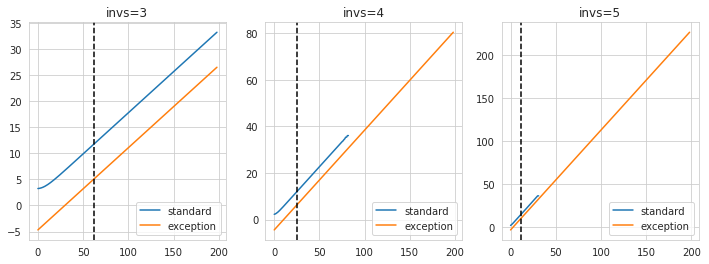

In [60]:
import seaborn as sns

def softplus(x):
    return np.log(1 + np.exp(x))

plt.figure(figsize=(12,4))
sns.set_style("whitegrid")
plt.subplot(221)
vals = {}
invss = [3, 4, 5]
for index, invs in enumerate(invss):
    vals[(invs, 'standard')] = []
    vals[(invs, 'exception')] = []
    vals[(invs, 'except_cont')] = []
    vertline = None
    mid_vert = 1e10
    for i in range(1, 200):
        centered_mean = i / 127.5
        offset = 1. / 127.5 / 2.
        cdfminus_arg = (centered_mean - offset) * np.exp(invs)
        cdfplus_arg = (centered_mean + offset) * np.exp(invs)
        mid_in = centered_mean * np.exp(invs)
        log_pdf_mid = -mid_in - invs - 2. * softplus(-mid_in)
        
        loss_standard = sigmoid(cdfplus_arg) - sigmoid(cdfminus_arg)
        loss_mid = mid_in - np.log(127.5)
        if loss_standard < 1e-5 and vertline is None:
            vertline = i
            mid_vert = loss_mid
            
        vals[(invs, 'standard')].append(-np.log(loss_standard))
        vals[(invs, 'exception')].append(loss_mid)
        if vertline is None:
            vals[(invs, 'except_cont')].append(np.nan)
        else:
            vals[(invs, 'except_cont')].append(loss_mid + (-np.log(1e-5) - mid_vert))
        
    ax = plt.subplot(1, len(invss), index + 1)
    ax.title.set_text('invs=%d' % invs)
    pd.Series(vals[(invs, 'standard')], name='standard').plot(ax=ax)
    pd.Series(vals[(invs, 'exception')], name='exception').plot(ax=ax)
    #pd.Series(vals[(invs, 'except_cont')], name='except_cont').plot(ax=ax)
    ax.axvline(x=vertline, linestyle='--', color='black')
    ax.legend()

* As you can see, directionally, the "normal" and the "exception" are pretty much aligned for different values of `invs` (black dotted line is the switch over point of `1e-5`)
* At some point the "standard" case blows up because you have a logarithm of a `0` (it's at some point near `1e-16` where it gets so small that it rounds down to `0`), resulting in `np.inf`.
* When you start getting large `invs` it happens much more quickly (`invs=5`).  So basically without this edge case, it would just stick with small `invs` values or else risk blowing up the loss.
* I feel like there is some way to make this function more continuous: for a given `invs`, find the cross over point `centered_mean` (black dotted line), then compute the difference between `standard` and `exception` and add it to the `exception` case.  I mean this would work but it's probably hard to find the cross over point analytically, and doing it on the fly seems like it would be computationally intensive.
* However, as long as your step size is small, I supposed the gradient will bias toward small `invs`, then slowly step towards larger `invs` when the mean gets closer.